# Task for Today  

***

## Food Image Classification  

Given *images of 101 different foods*, let's try to classifify the **food** present in a given image.

We will use a TensorFlow/Keras pretrained MobileNetV2 CNN to make our predictions.

# Getting Started

In [13]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report

In [14]:
image_dir = Path('../recipes gen/images')

# Creating File DataFrame

In [15]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

ValueError: No objects to concatenate

In [ ]:
image_df

,Filepath,Label
0,..\recipes gen\images\paella\1769909.jpg,paella
1,..\recipes gen\images\steak\2815172.jpg,steak
2,..\recipes gen\images\bread_pudding\272991.jpg,bread_pudding
3,..\recipes gen\images\waffles\1854304.jpg,waffles
4,..\recipes gen\images\french_toast\3009499.jpg,french_toast
...,...,...
10095,..\recipes gen\images\croque_madame\3389786.jpg,croque_madame
10096,..\recipes gen\images\poutine\227190.jpg,poutine
10097,..\recipes gen\images\breakfast_burrito\790446...,breakfast_burrito
10098,..\recipes gen\images\guacamole\2979136.jpg,guacamole


In [ ]:
image_df['Label'].value_counts()

Label
paella                  100
red_velvet_cake         100
baby_back_ribs          100
shrimp_and_grits        100
cup_cakes               100
                       ... 
takoyaki                100
pad_thai                100
fried_rice              100
strawberry_shortcake    100
apple_pie               100
Name: count, Length: 101, dtype: int64

# Train-Test Split

In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# Creating Generators

In [ ]:
from tensorflow.keras.applications import mobilenet_v3

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=mobilenet_v3.preprocess_input,
    validation_split=0.3
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=mobilenet_v3.preprocess_input
)


In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4949 validated image filenames belonging to 101 classes.
Found 2121 validated image filenames belonging to 101 classes.
Found 3030 validated image filenames belonging to 101 classes.


# Modeling

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)


pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

# Training

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
155/155 [==============================] - 20s 109ms/step - loss: 4.9648 - accuracy: 0.0194 - val_loss: 4.4728 - val_accuracy: 0.0448
Epoch 2/20
155/155 [==============================] - 15s 97ms/step - loss: 4.2683 - accuracy: 0.0566 - val_loss: 4.0729 - val_accuracy: 0.0736
Epoch 3/20
155/155 [==============================] - 16s 101ms/step - loss: 3.8406 - accuracy: 0.1022 - val_loss: 3.8333 - val_accuracy: 0.1183
Epoch 4/20
155/155 [==============================] - 15s 96ms/step - loss: 3.4396 - accuracy: 0.1709 - val_loss: 3.6937 - val_accuracy: 0.1447
Epoch 5/20
155/155 [==============================] - 16s 101ms/step - loss: 3.0784 - accuracy: 0.2239 - val_loss: 3.5078 - val_accuracy: 0.1848
Epoch 6/20
155/155 [==============================] - 15s 96ms/step - loss: 2.7352 - accuracy: 0.2944 - val_loss: 3.4636 - val_accuracy: 0.1980
Epoch 7/20
155/155 [==============================] - 16s 101ms/step - loss: 2.4943 - accuracy: 0.3447 - val_loss: 3.3933 - val_accur

UnknownError: Graph execution error:

2 root error(s) found.
  (0) UNKNOWN:  FileNotFoundError: [Errno 2] No such file or directory: '..\\recipes gen\\images\\apple_pie\\829830.jpg'
Traceback (most recent call last):

  File "c:\Users\benha\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "c:\Users\benha\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\Users\benha\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "c:\Users\benha\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "c:\Users\benha\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\data_adapter.py", line 1050, in generator_fn
    yield x[i]

  File "c:\Users\benha\Anaconda3\envs\tensorflow\lib\site-packages\keras\preprocessing\image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "c:\Users\benha\Anaconda3\envs\tensorflow\lib\site-packages\keras\preprocessing\image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "c:\Users\benha\Anaconda3\envs\tensorflow\lib\site-packages\keras\utils\image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: '..\\recipes gen\\images\\apple_pie\\829830.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) UNKNOWN:  FileNotFoundError: [Errno 2] No such file or directory: '..\\recipes gen\\images\\apple_pie\\829830.jpg'
Traceback (most recent call last):

  File "c:\Users\benha\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "c:\Users\benha\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "c:\Users\benha\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "c:\Users\benha\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "c:\Users\benha\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\data_adapter.py", line 1050, in generator_fn
    yield x[i]

  File "c:\Users\benha\Anaconda3\envs\tensorflow\lib\site-packages\keras\preprocessing\image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "c:\Users\benha\Anaconda3\envs\tensorflow\lib\site-packages\keras\preprocessing\image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "c:\Users\benha\Anaconda3\envs\tensorflow\lib\site-packages\keras\utils\image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: '..\\recipes gen\\images\\apple_pie\\829830.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_15065]

# Results

In [ ]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

95/95 [==============================] - 7s 66ms/step


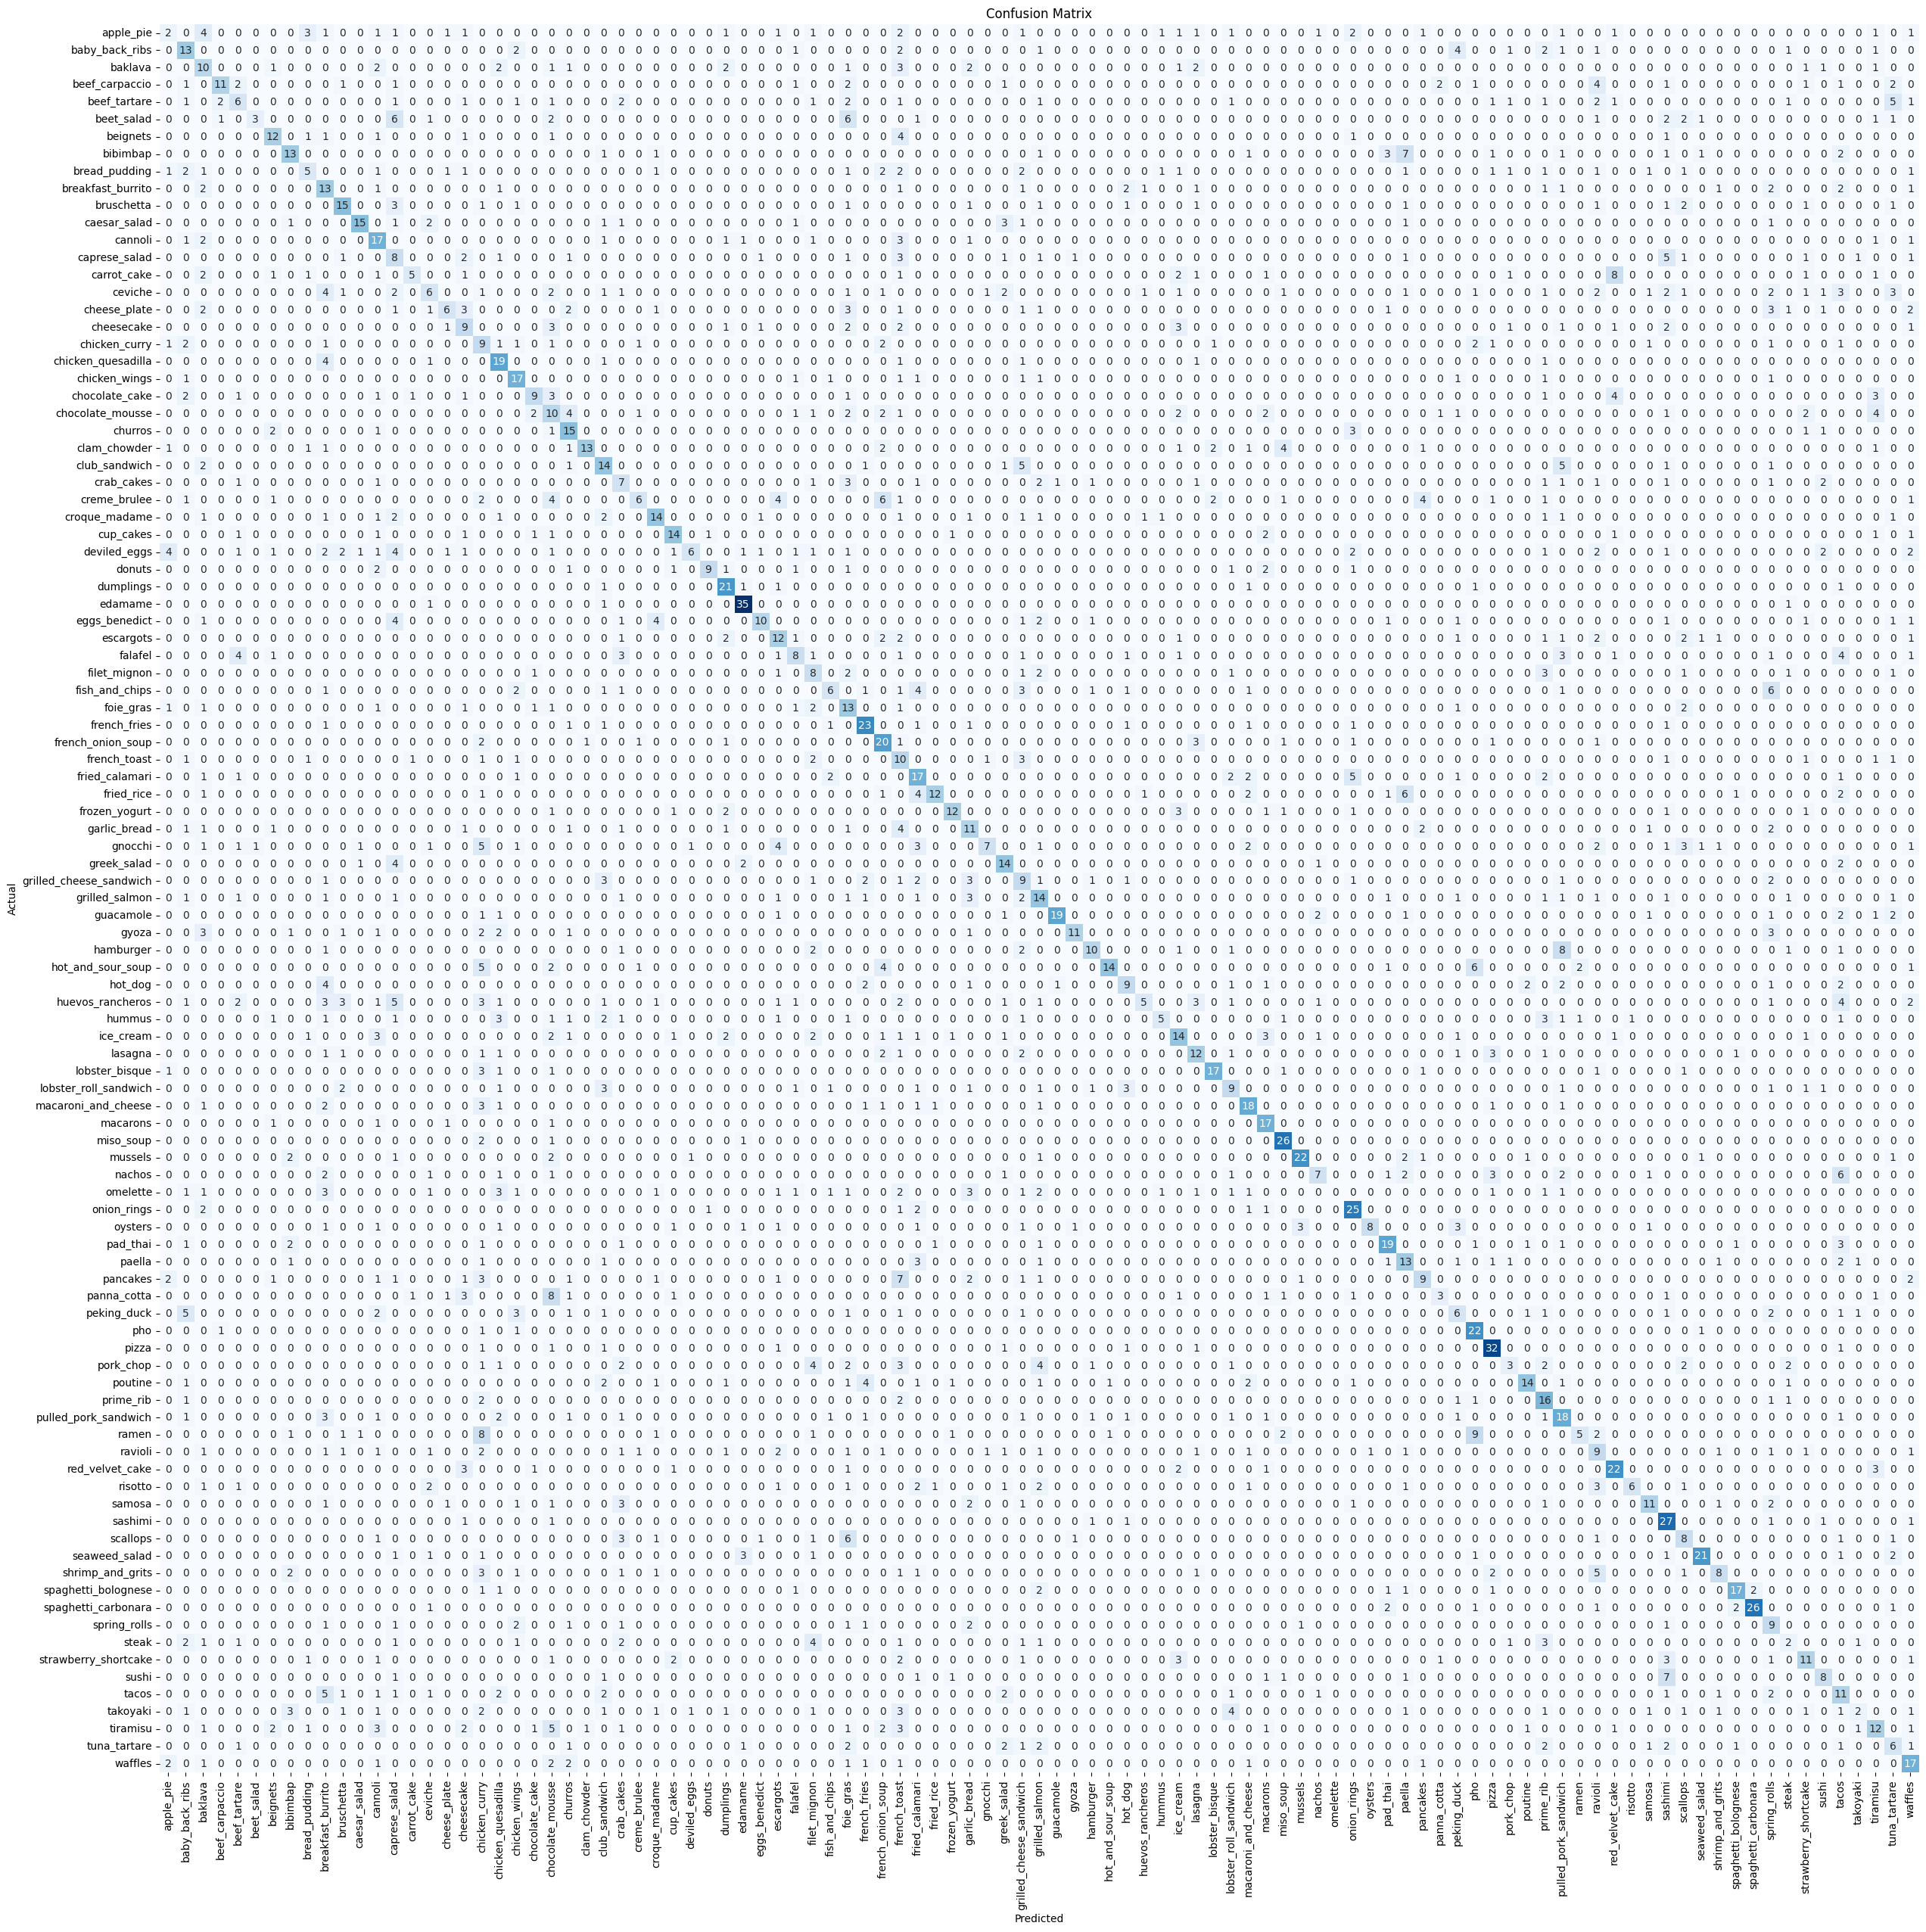

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.13      0.06      0.09        32
         baby_back_ribs       0.32      0.43      0.37        30
                baklava       0.23      0.32      0.27        31
         beef_carpaccio       0.73      0.34      0.47        32
           beef_tartare       0.25      0.18      0.21        34
             beet_salad       0.75      0.11      0.19        28
               beignets       0.48      0.52      0.50        23
               bibimbap       0.50      0.39      0.44        33
          bread_pudding       0.33      0.17      0.22        30
      breakfast_burrito       0.21      0.42      0.28        31
             bruschetta       0.48      0.47      0.48        32
           caesar_salad       0.79      0.54      0.64        28
                cannoli       0.32      0.57      0.41        30
          caprese_salad       0.15      0.

# Data Every Day  

This notebook is featured on Data Every Day, a YouTube series where I train models on a new dataset each day.  

***

Check it out!  
https://youtu.be/35iRdqY01co